In [1]:
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import pickle

In [3]:
os.chdir(r'/Users/samueleckford/Python/Covid_19/covid_19_analysis/datasets')

In [4]:
train_X = pd.read_csv("./data/train/train_x.csv", index_col=0).drop(columns=['dateRep'])
train_y = pd.read_csv("./data/train/train_y.csv", index_col=0).drop(columns=['dateRep'])

df_x = pd.read_csv("./data/test/test_x.csv", index_col=0).drop(columns=['dateRep'])
df_y = pd.read_csv("./data/test/test_y.csv", index_col=0)

In [5]:
params = {'max_depth':[5, 10, 15],
          'eta': [0.1, 0.2, 0.3, 0.5],
          'n_estimators': [50, 100, 200],
          'min_child_weight':[1, 2, 3, 5],
          'gamma': [1, 2, 3, 5]}

In [6]:
xgbr = XGBRegressor(objective="reg:squarederror",
                    eval_metric='mae',
                    num_round=30,
                    silent = 0)

In [7]:
model = GridSearchCV(estimator=xgbr,
                     param_grid=params,
                     scoring='neg_mean_absolute_error',
                     cv=10,
                     verbose=1,
                     n_jobs=-1)

In [151]:
model.fit(train_X.values, train_y.values)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  7.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, eval_metric='mae',
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nthread=None, num_round=30,
                                    objective='reg:squared...
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=0,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.1, 0.2, 0.3, 0.5], 'gamma': [1

In [8]:
#if os.path.exists("./model") is False:
#    os.mkdir("./model")
#pickle.dump(model, open("./model/xgb.pkl", "wb"))
model = pickle.load(open("/Users/samueleckford/Python/Covid_19/covid_19_analysis/datasets/model/xgb.pkl", "rb"))

In [9]:
# Concatenate together the test x and y dataframes
df = pd.concat([df_x, df_y], axis=1)
# Merge the train X and y dataframes
df1 = train_X.merge(train_y, left_index=True, right_index=True)

In [10]:
# Predicting the daily deaths for each country using our model
y_pred = model.predict(df_x.values) # model.predict(df_x[train_X.columns].values)
df["deaths_pred"] = y_pred
# Computing the model error
df["model_error"] = df["deaths"] - df["deaths_pred"]

In [11]:
print(f"XGBoost MAE score: {np.round(mean_absolute_error(df.deaths, df.deaths_pred))}")
print(f"XGBoost R2 score: {np.round(r2_score(df.deaths, df.deaths_pred), 4)}")

XGBoost MAE score: 118.0
XGBoost R2 score: 0.8189


In [12]:
# Append df and df1 so that we now have the complete dataframe again
df = df.append(df1)
# Import in the covid19_df from the data prep stage for a full comparison to the predictions
df_global = pd.read_csv(r"./Data_Export/covid19_df.csv", index_col=0)
# Merge the df_global dataframe with the predicted deaths and model error columns we created
df_global = df_global.merge(df[['deaths_pred', 'model_error']], left_index=True, right_index=True)
# Calculate the cumulative error in the model for each country using a 'groupby'
df_global['cumulative_error'] = df_global.groupby('countriesAndTerritories')['model_error'].cumsum()
# Recreate the top_count list using the line below
top_count = list(df_global.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20].keys())

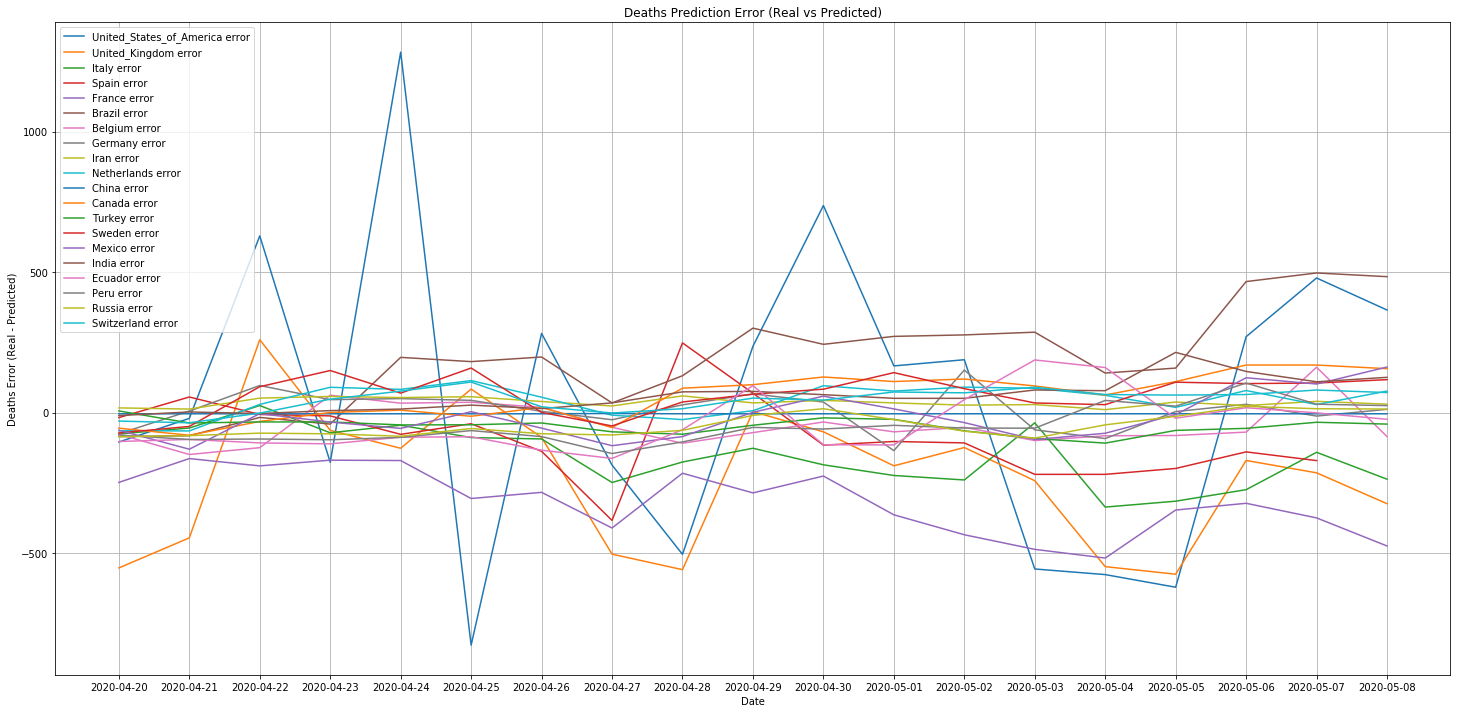

In [13]:
#plt.style.use('classic')
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['model_error'], label=f"{country} error")
plt.title('Deaths Prediction Error (Real vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Deaths Error (Real - Predicted)')
plt.grid()
plt.legend()
plt.show()

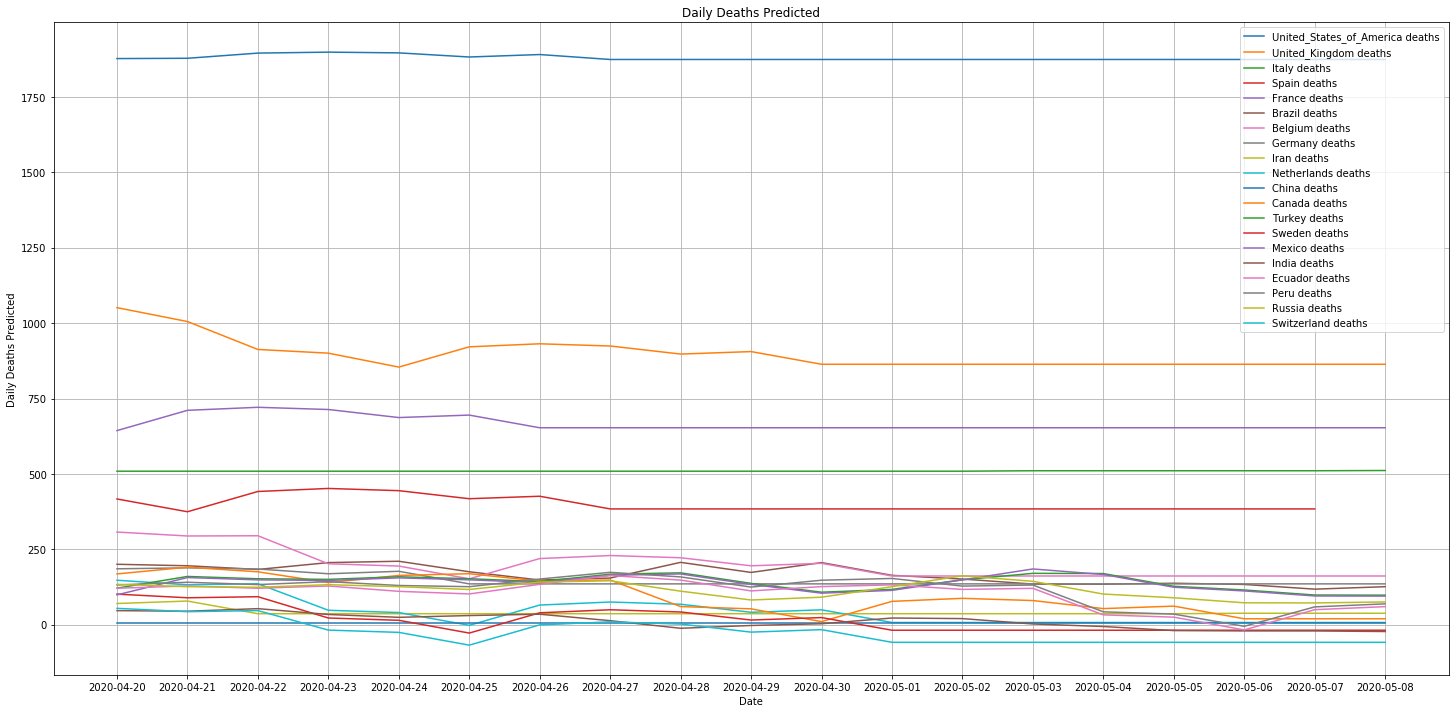

In [14]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['deaths_pred'], label=f"{country} deaths")
plt.title('Daily Deaths Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Deaths Predicted')
plt.grid()
plt.legend()
plt.show()

In [20]:
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

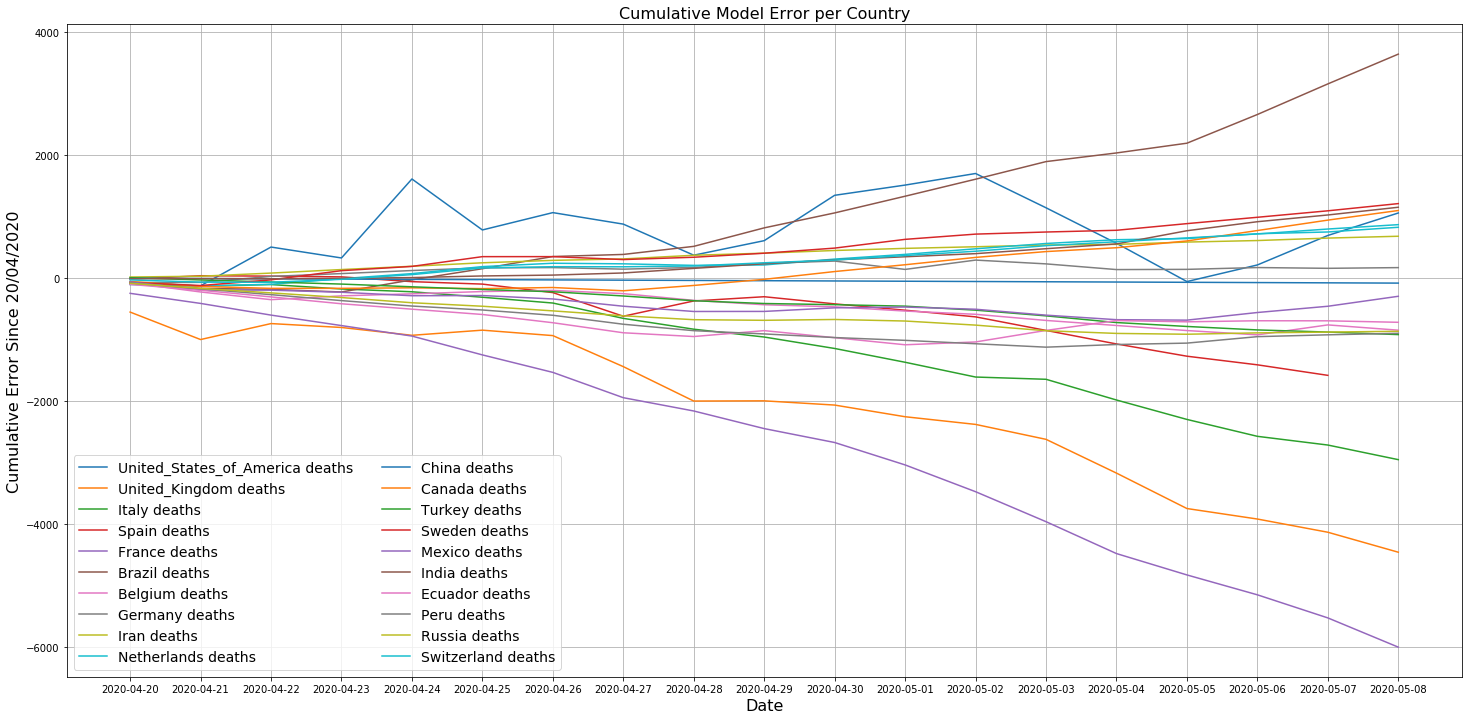

In [22]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['cumulative_error'], label=f"{country} deaths")
plt.title('Cumulative Model Error per Country')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Error Since 20/04/2020')
plt.grid()
plt.legend(ncol=2)
plt.savefig('cumulative_error_20_countries_dpi600.jpeg', dpi=600)

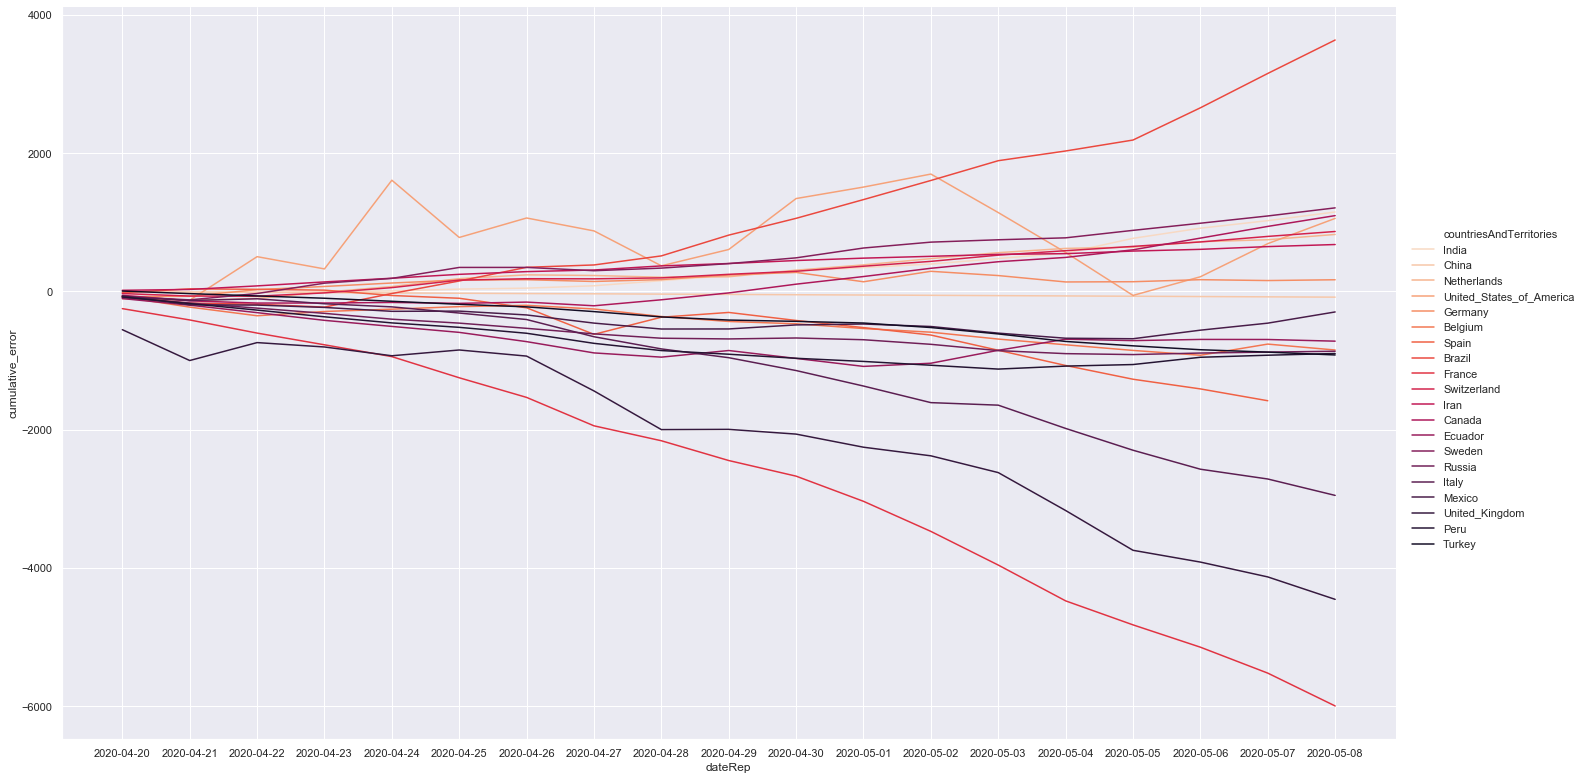

In [75]:
# Define a palette to ensure that colors will be
# shared across the facets
#sns.set_context(font_scale=101.5)
palette = dict(zip(df_global.countriesAndTerritories.unique(),
                   sns.color_palette("rocket_r", len(top_count))))
sns.set(rc={'figure.figsize':(12,9)}) #,font_scale=1.8)
# Plot the lines
g = sns.relplot(x="dateRep", y="cumulative_error",
            hue="countriesAndTerritories", palette=palette,
            height=11, aspect=1.8, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=df_global)
plt.savefig('residual_deaths_20_countries_dpi600.jpeg', dpi=600)

In [204]:
if os.path.exists("model_predictions") is False:
    os.mkdir("./model_predictions")
df_global.to_csv("./model_predictions/xgb_predictions.csv")

Text(0.5, 0, 'Prediction error (m)')

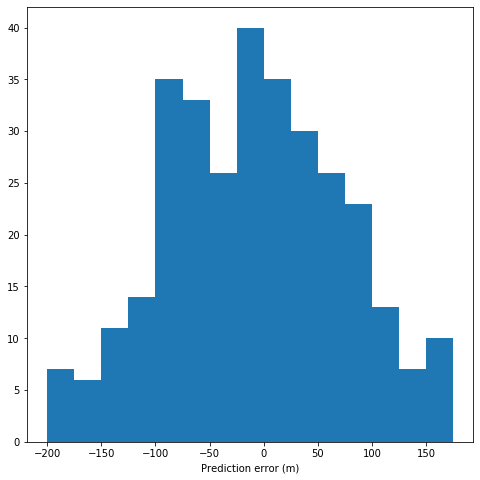

In [29]:
#plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.hist(df["model_error"], bins=np.arange(-200, 200,25))
plt.xlabel("Prediction error (m)")
#plt.show()

Text(0, 0.5, 'predicted Deaths')

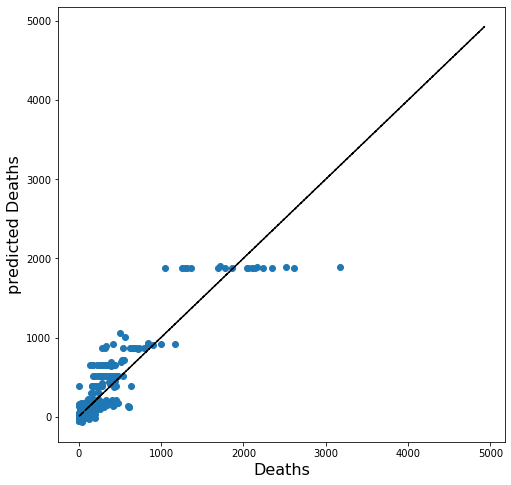

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(df.deaths, df.deaths_pred)
plt.plot(df.deaths, df.deaths, color="black", linestyle="--")
plt.xlabel("Deaths")
plt.ylabel("predicted Deaths")
#plt.show()